# Example pipeline: WMAP model

<span style="color:red">WARNING: this tutorial is still under development!</span>

In this tutorial, we will illustrate a more realistic use of IMAGINE: to show how to constrain a few parameters of the WMAP GMF model. 

We will first prepare a mock dataset, using Hammurabi itself for this. Then, assemble the pipeline and execute it.

First, let us import the necessary packages.

In [1]:
# Builtin 
import os
# External packages 
import numpy as np
import healpy as hp
import astropy.units as u
import corner
import matplotlib.pyplot as plt
# IMAGINE
import imagine as img
import imagine.observables as img_obs
## WMAP field factories
from imagine.fields.hamx import BregLSA, BregLSAFactory
from imagine.fields.hamx import TEregYMW16, TEregYMW16Factory
from imagine.fields.hamx import CREAna, CREAnaFactory
from imagine.fields.hamx import BrndES, BrndESFactory

## Preparing the mock data

Let's make a very low resolution map of synchrotron total I and Faraday depth from the WMAP model, including a random compnent:

In [2]:
## Sets the resolution
nside=2
size = 12*nside**2 

# Generates the fake datasets 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(size)*u.K, 
                                              frequency=23, type='I')
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=np.empty(size)*u.rad/u.m**2)

# Appends them to an Observables Dictionary
trigger = img_obs.Measurements()
trigger.append(dataset=sync_dset)
trigger.append(dataset=fd_dset)

# Prepares the Hammurabi simmulator for the mock generation
mock_generator = img.simulators.Hammurabi(measurements=trigger)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


We will feed the `mock_generator` simulator with selected Dummy fields.

In [3]:
# BregLSA field
breg_lsa = BregLSA(parameters={'b0':3, 'psi0': 27.0, 'psi1': 0.9, 'chi0': 25.0})

# CREAna field
cre_ana = CREAna(parameters={'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
                             'r0': 5.0, 'z0': 1.0,
                             'E0': 20.6, 'j0': 0.0217})

# TEregYMW16 field
tereg_ymw16 = TEregYMW16(parameters={})

## Random field
brnd_es = BrndES(parameters={'rms': 3., 'k0': 0.5, 'a0': 1.7,
                             'k1': 0.5, 'a1': 0.0,
                             'rho': 0.5, 'r0': 8., 'z0': 1.},
                 grid_nx=25, grid_ny=25, grid_nz=15)

In [4]:
## Generate mock data (run hammurabi)
outputs = mock_generator([breg_lsa, brnd_es, cre_ana, tereg_ymw16])

To make a realistic mock, we add to these outputs, which where constructed from a model with known parameter, some noise, which assumed to be proportional to the average synchrotron intensity.

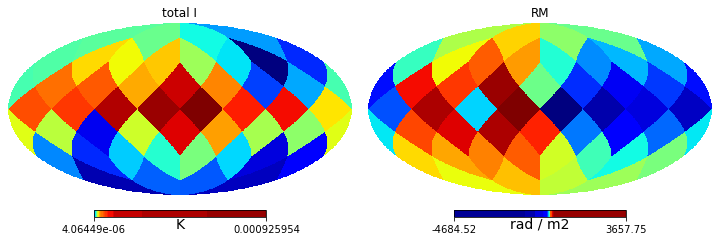

In [5]:
## Collect the outputs
mockedI = outputs[('sync', '23', str(nside), 'I')].global_data[0]
mockedRM = outputs[('fd', 'nan', str(nside), 'nan')].global_data[0]
dm=np.mean(mockedI)
dv=np.std(mockedI)

## Add some noise that's just proportional to the average sync I by the factor err
err=0.01
dataI = (mockedI + np.random.normal(loc=0, scale=err*dm, size=size)) << u.K
errorI = ((err*dm)**2) << u.K
sync_dset = img_obs.SynchrotronHEALPixDataset(data=dataI, error=errorI,
                                              frequency=23, type='I')

## Just 0.01*50 rad/m^2 of error for noise.  
dataRM = (mockedRM + np.random.normal(loc=0.,scale=err*50.,size=12*nside**2))*u.rad/u.m/u.m
errorRM = ((err*50.)**2) << u.rad/u.m**2
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=dataRM, error=errorRM)


fig = plt.figure(figsize=(10.0, 4.0))
hp.mollview(dataI, norm='hist', cmap='jet',sub=(1,2,1),title="total I",unit=dataI.unit, fig=fig)
hp.mollview(dataRM, norm='hist', cmap='jet',sub=(1,2,2),title="RM",unit=dataRM.unit,fig=fig)

We are ready to include the above data in `Measurements` and  objects

In [6]:
mock_data = img_obs.Measurements()
mock_data.append(dataset=sync_dset)
mock_data.append(dataset=fd_dset)

mock_cov = img_obs.Covariances()
mock_cov.append(dataset=sync_dset)
mock_cov.append(dataset=fd_dset)

## Assembling the pipeline

After preparing our mock data, we can proceed with the set up of the IMAGINE pipeline. First, we initialize the `Likelihood`, using the mock observational data

In [7]:
## Use an ensemble to estimate the galactic variance
likelihood = img.likelihoods.EnsembleLikelihood(mock_data, mock_cov)

Then, we prepara the `FieldFactory` list:

In [8]:
## WMAP B-field, vary only b0 and psi0
breg_factory = BregLSAFactory()
breg_factory.active_parameters = ('b0', 'psi0')
breg_factory.priors = {'b0':  img.priors.FlatPrior(interval=[0., 10.]), 
                      'psi0': img.priors.FlatPrior(interval=[0., 50.])}
## Random B-field, vary only RMS amplitude
brnd_factory = BrndESFactory(grid_nx=25, grid_ny=25, grid_nz=15)
brnd_factory.active_parameters = ('rms',)
brnd_factory.priors = {'rms': img.priors.FlatPrior(interval=[0., 10.])}
## Fixed CR model
cre_factory = CREAnaFactory()
## Fixed FE model
fereg_factory = TEregYMW16Factory()

# Final Field factory list
factory_list = [breg_factory, brnd_factory, cre_factory,
                fereg_factory]

We initialize the `Simulator`, in this case: `Hammurabi` .

In [9]:
simulator = img.simulators.Hammurabi(measurements=mock_data)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


Finally, we initialize and setup the `Pipeline` itself, using the `Multinest` sampler.

In [11]:
# Creates a directory for MultiNest's chains
chains_dir = '../examples/pipeline_example_chains'
os.makedirs(chains_dir, exist_ok=True)

# Assembles the pipeline using MultiNest as sampler
pipeline = img.pipelines.MultinestPipeline(simulator=simulator, 
                                           factory_list=factory_list, 
                                           likelihood=likelihood, 
                                           ensemble_size=20,
                                           chains_directory=chains_dir)
pipeline.sampling_controllers = {'n_live_points': 500}

We created a directory `'chaipipeline_example_chains_dir'` for storing MultiNest's the chains during this IMAGINE run. This is convenient for inspecting the progress of this sampler, but not compulsory: if the argument `chains_directory` is absent, a temporary directory is created instead (and is deleted after completion).

## Checking and running

We can now finally run the pipeline using:
```python
results=pipeline()
```

However, before running a heavy job, it is a good idea to be able to roughly estimate how long it will take (so that one can e.g. decide whether one will read emails, prepare some coffee, or take a week of holidays while waiting for the results).

One thing that can be done is checking how long the code takes to do an individual likelihood function evaluation (note that each of these include the whole ensemble).  The final likelihood function handled to the sampler can be accessed through the internal method `_likelihood_function`, which takes an array of parameter values scaled to the [0,1] interval. Below we time a randomly picked point (the timing was done on a regular personal computer).

In [12]:
%time pipeline._likelihood_function(np.array([0.5,0.5,0.5]))

CPU times: user 239 ms, sys: 302 ms, total: 541 ms
Wall time: 2min


20.430949072404644

This is a large amount of time! Note that many hundreds of evaluations will be needed to be able to estimate the evidence and/or posterior distributions.

Thus, we will not run the pipeline on this on this notebook. Intead, we ran the script [examples/example_pipeline.py](../examples/example_pipeline.py) on a more powerful machine (and the reader may want to inspect the script and do the same). 

## Monitoring the progress

Standardized tools for progress monitoring an IMAGINE run are now *still under development*.  Here we illustrate how to keep track of *specifically* of a MultiNest pipeline by inspecting the information dumped to its chains directory.

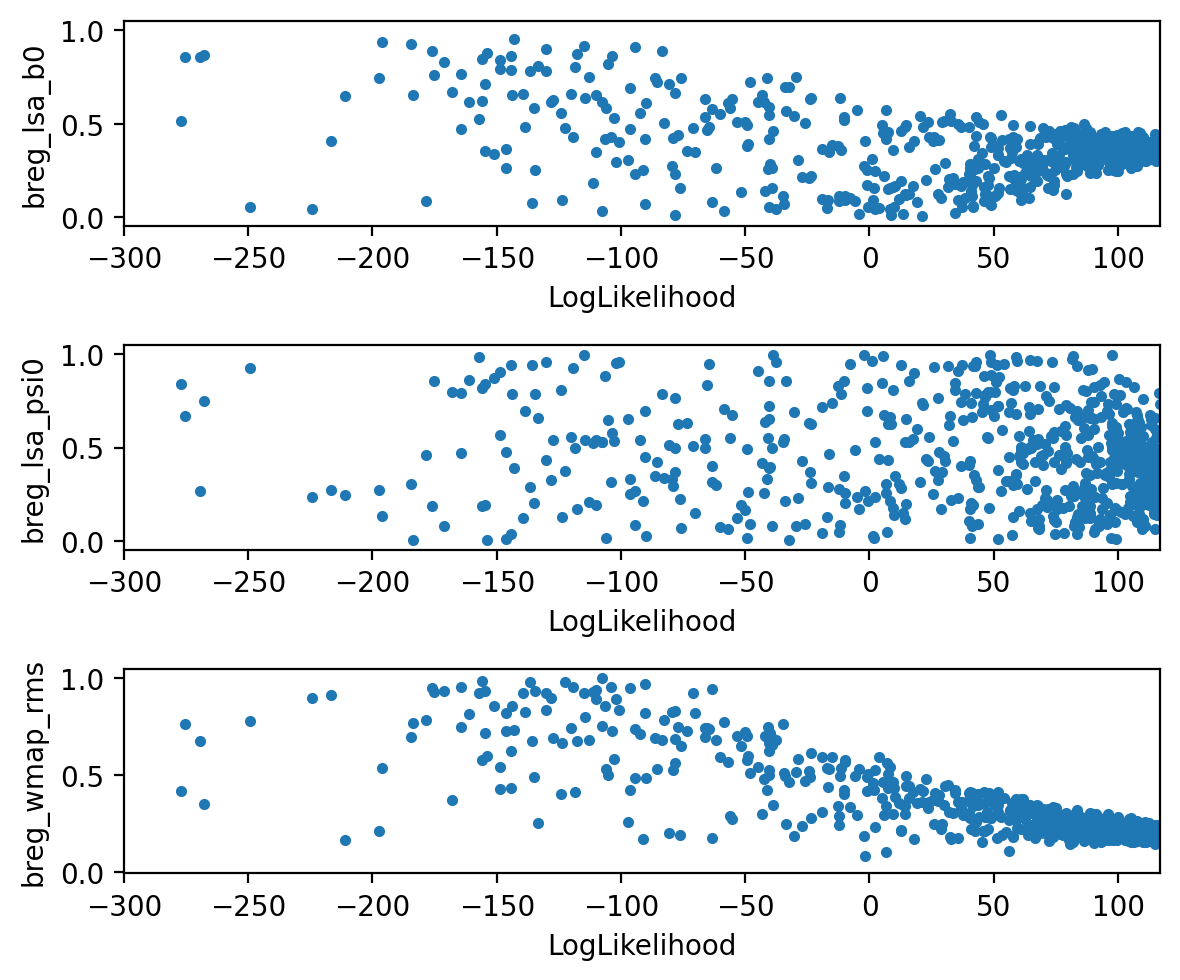

In [13]:
import numpy as np
import matplotlib.pyplot as plt

live = np.genfromtxt('../examples/pipeline_example_chains/phys_live.points')
rejected = np.genfromtxt('../examples/pipeline_example_chains/ev.dat')
plt.figure(figsize=(6,5), dpi=200)
for i in range(3):
    plt.subplot(3, 1, 1+i)
    plt.plot(rejected[:,3], rejected[:,i],  '.')
    plt.xlim(-300,rejected[:,3].max())
    plt.xlabel('LogLikelihood')
    plt.ylabel(pipeline.active_parameters[i])
plt.tight_layout()

<!-- import numpy as np
import matplotlib.pyplot as plt
from corner import corner

sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)
corner(live[:,:3],
              labels=['b0','psi0','rms'],
#               range=[(1,5),(10.,40.),(1,5)],
              quantiles=[0.05, 0.5, 0.95],  ## These are the vertical lines in the 1D marginalized plots
              show_titles=True,
              title_kwargs={"fontsize": 15},
              color='steelblue',
              truths=[3,27,3],
              truth_color='firebrick',
              plot_contours=True,
              hist_kwargs={'linewidth': 2},
              label_kwargs={'fontsize': 20},
              levels=levels  ## replacing defaults (0.5,1,1.5,2 sigma) with 1,2,3
              );
 -->